## Makine Öğrenmesi Dersleri 8: Hiper-parametre Kestirimi

Hiper-parametre seçimi (hyper-parameter tuning) elinizle radyo frekansı ayarlamaya benziyor. Hani ses iyidir ama siz bi tık daha iyi olmasını istersiniz ve milimetrik parmak dokunuşları yaparsınız ya işte hiper-parametre seçimi de makine öğrenmesi modelleri için o işe yarıyor.

Örnek veri seti olarak elimizde Portekiz bankasından alınmış 11 bin kişinin yaşı, mesleği, medeni durumu, ev kredisi alıp almadığı, son görüşmeden sonra geçen zaman, görüşmenin sabit telefonla mı cep telefonuyla mı gerçekleştiği gibi öznitelikler var. Kişilerin bankaya depozito yatırıp yatırmayacağını tahmin eden bir model kurmaya çalışıyoruz. Çıkacak sonuçlara göre belirli kişilere ve gruplara kişiselleştirilmiş pazarlama yöntemleri uygulanabilir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/HakkiKaanSimsek/Makine_Ogrenmesi_Dersleri/master/hiper_parametre_kestirimi/data/bank_marketing.csv')
print(df.info())
print('')
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


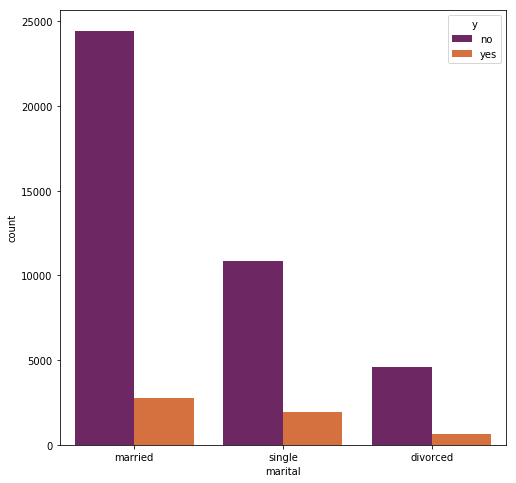

In [2]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'marital', hue = 'y', data=df,palette = 'inferno')
plt.show()

Bekar insanların evli insanlara kıyasla bankada vadeli para tutma oranının fazla olduğunu görüyoruz.

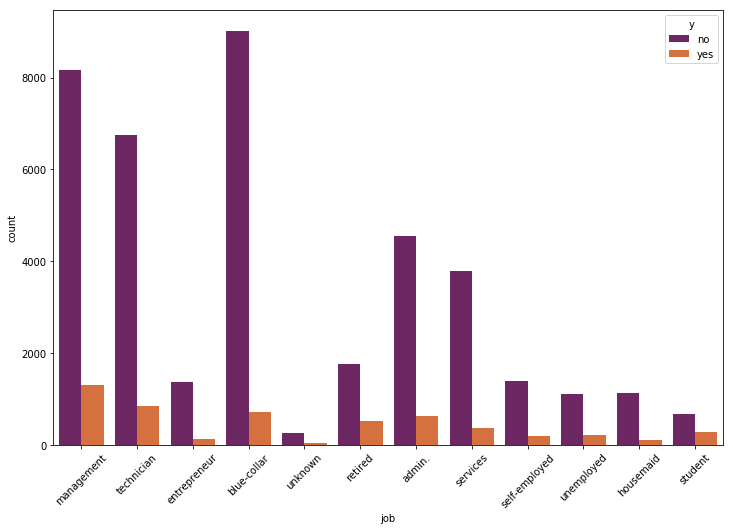

In [3]:
plt.figure(figsize=(12,8))
sns.countplot(x = 'job', hue = 'y', data=df,palette = 'inferno')
plt.xticks(rotation=45)
plt.show()

Yukarıdaki tabloda meslek dağılımlarına göre kişilerin bankaya vadeli para yatırıp yatırmadıklarını görüyoruz. Örneğin mavi yakalılarda durum hiç açıcı değil. Buradan hareketle farklı pazarlama kampanyaları düşünülebilir.

Son olarak depozita yatırmakla diğer değişkenler arasındaki korelasyona bakmak istiyorum. One-hot-encoder yöntemiyle kategorik değişkenleri binary (0,1) hale getiriyorum aksi halde makine ne cinsiyeti ne medeni durumu ne de iş güç hiçbir şey anlamaz.

In [4]:
columns = df.select_dtypes(include='object').columns
df = pd.concat([df, pd.get_dummies(df[columns])], axis=1)
df = df.drop(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'poutcome', 'y', 'y_no'], axis =1)
df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


Gördüğünüz gibi satır sayısı 17'den 52'ye çıktı. Sakın korkmayın bilgisayarlar için bu boyutlarda işlem yapmak hala çok kolay.

52*52 bir korelasyon matrisine bakmak pek mümkün değil onun için depozito yatırmakla en yüksek korelasyonu olan 10 değişkeni seçiyoruz.

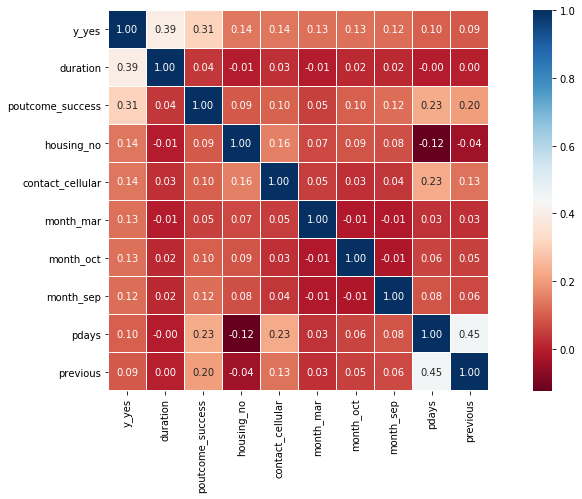

In [5]:
a,x = plt.subplots(figsize=(16, 7))
corr = df.corr()
max_corr = corr.nlargest(10, 'y_yes')['y_yes'].index
cm = np.corrcoef(df[max_corr].values.T)
matrix = sns.heatmap(cm, annot=True, square=True, fmt='.2f', 
                 linewidths= 0.1, vmax = 1, cmap = 'RdBu',
                  yticklabels=max_corr.values, xticklabels=max_corr.values, ax = x)
plt.show()

Depozito yatırmakla en yüksek pozitif korelasyonu olan 5 öznitelik:
- Son telefon konuşmasının uzunluğu (son konuşmanın süresi 0'sa kişi telefonda ikna edilmemiştir, o yüzden çok iyi bir öznitelik olmayabilir.)
- Bir önceki pazarlama kampanyasının başarılı sonuç vermesi.
- Ev kredisi alınmaması.
- Konuşmanın sabit telefon yerine cep telefonu ile gerçekleşmesi.

Bu yazının konusu hiper-parametre seçimi olduğu için açıklayıcı veri analizi kısmını burada bitiriyorum ama gördüğünüz gibi sadece veriyi analiz ederek bile harika bulgular elde ediyoruz.

In [6]:
y = df.y_yes
df = df.drop(['y_yes'], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

Hedef değişkenimizi tutuyoruz. Sonrasında veri setimizi train ve test setlerine ayırıyoruz, buraya kadar her şey oldukça basit şimdi random forest modelimizi kuralım.

             precision    recall  f1-score   support

      <=50K       0.90      0.99      0.94     11966
       >50K       0.77      0.16      0.27      1598

avg / total       0.88      0.90      0.86     13564



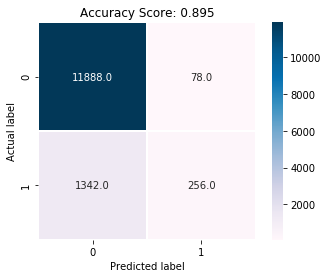

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            random_state=0, max_features= 10, 
                            max_depth= 5)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print(classification_report(y_test, rf_predict, target_names=['<=50K', '>50K']))

score = round(accuracy_score(y_test, rf_predict),3)
cm1 = cm(y_test, rf_predict)

sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
            square = True, cmap = 'PuBu')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()

Sonuçlar hiç de kötü değil. Hiç görmediğimiz bir veri setinde %89.5 olasılıkla doğru tahminler yapıyoruz. Geçen hafta öğrendiğimiz cross-validation metodunu uygulayalım şimdi de.

In [8]:
from sklearn.model_selection import GridSearchCV, cross_val_score

print(cross_val_score(RandomForestClassifier(n_estimators=100, 
                                 n_jobs=-1, random_state=0, max_features= 10, 
                            max_depth= 5), 
                              X_train, y_train, cv=5))
print('')
print('mean of cv-scores: {0}'.format(round(np.mean(cross_val_score(RandomForestClassifier(n_estimators=100, 
                                 n_jobs=-1, random_state=42, max_features= 10, 
                            max_depth= 5), 
                              X_train, y_train, cv=5)),4)))

[0.89717264 0.89650814 0.89666614 0.89508611 0.89398009]

mean of cv-scores: 0.8961


Modelin 5 farklı eğitim ve test veri setindeki ortalaması %89.6 yani az önce şans eseri %89.5 gibi bir doğruluk oranı yakalamadık modelimiz gayet iyi çalışıyor.

Daha gidecek yol var mı bi bakalım…

In [14]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                random_state=0)

rf_params = {'max_depth': range(3,13), 'max_features': range(5,15)}

rf_grid = GridSearchCV(rf, rf_params,
                           cv=5, n_jobs=-1, 
                       verbose=True)

rf_grid.fit(X_train, y_train)
print('')
print(rf_grid.best_params_)
print('Best cv mean result: {0}'.format(round(rf_grid.best_score_,5)))
print('Best holdout result: {0}'.format(round(accuracy_score(y_test, rf_grid.predict(X_test)),5)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   56.3s finished



{'max_depth': 12, 'max_features': 14}
Best cv mean result: 0.90641
Best holdout result: 0.90467


GridSearch bizim için 500 farklı kombinasyonu deneyerek en iyi sonuçlar veren hiper-parametreleri seçti. (max_depth:12, max_features:14)

Bu hiper-parametreler kurularak bir model kurulduğunda en iyi doğruluk oranı %90.6, bizim ilk modeli kurduğumuz eğitim ve test veri setindeki doğruluk oranı %90.4. (ilk model: %89.5)

Yukarıdaki adımlar izlenerek diğer makine öğrenmesi modellerinde de basitçe hiper-parametre kestirimi yapılabilir.

Örneğin knn için params = {'knn__n_neighbors': range(1, 5)} yazarak GridSearchCV yapabilirsiniz.